[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with custom encoding error
handler: 'OutStream' object has no attribute 'reconfigure'


2024-09-16 11:44:45.130 |       INFO       |  - You are connecting to finney network with endpoint wss://entrypoint-finney.opentensor.ai:443. - 
2024-09-16 11:44:45.130 |     WARNING      |  - We strongly encourage running a local subtensor node whenever possible. This increases decentralization and resilience of the network. - 
2024-09-16 11:44:45.130 |     WARNING      |  - In a future release, local subtensor will become the default endpoint. To get ahead of this change, please run a local subtensor node and point to it. - 
2024-09-16 11:44:45.669 |       INFO       |  - Connected to finney network and wss://entrypoint-finney.opentensor.ai:443. - 
Validator 149.36.1.121 is available...
Validator 192.150.253.122 is not accessible...
Validator 165.227.153.108 is available...
Validator 34.147.54.95 is not accessible...
Validator 34.44.71.163 is not accessible...
Validator 64.226.93.21 is available...
Validator 172.93.55.221 is available...
Validator 34.31.27.55 is not accessible...
Val

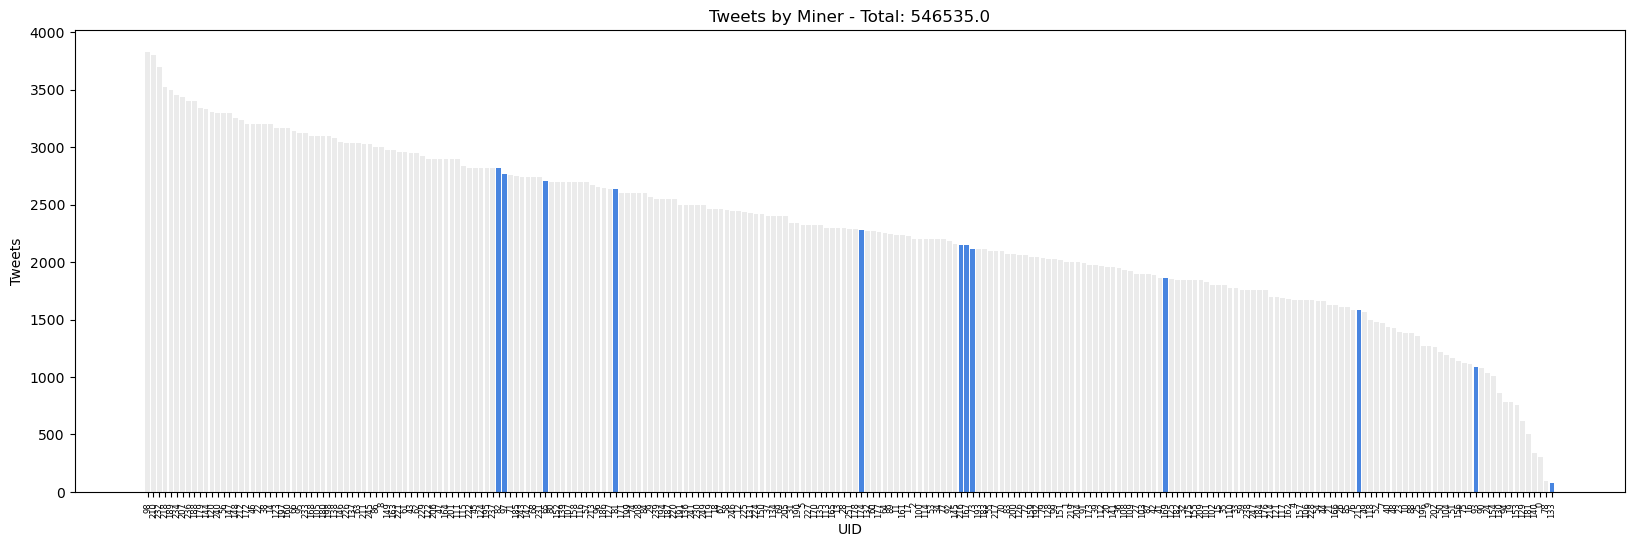

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import requests
import bittensor as bt

tempos = 6
miners_to_highlight = ["81", "216", "215", "97", "65", "73", "174", "93", "169", "167", "133", "82"]

# Connect to the mainnet bittensor netuid 42 and pull the metagraph of axons
subtensor = bt.subtensor(network="finney")
metagraph = subtensor.metagraph(netuid=42)
stakes = metagraph.S
axons = metagraph.axons
validator_axons = [axons[i] for i in range(len(axons)) if stakes[i] >= 1000]
validator_ips = [axon.ip for axon in validator_axons if axon.ip != '0.0.0.0']

healthy_validator_ips = []
for ip in validator_ips:
    try:
        response = requests.get(f"http://{ip}:8000/healthcheck", timeout=5)
        if response.ok:
            healthy_validator_ips.append(ip)
            print(f"Validator {ip} is available...")
    except requests.exceptions.RequestException as e:
        print(f"Validator {ip} is not accessible...")

# Fetch volumes from healthy validators
all_volumes = []
for ip in healthy_validator_ips:
    try:
        response = requests.get(f"http://{ip}:8000/volumes", timeout=5)
        if response.ok:
            volumes = response.json()
            all_volumes.extend(volumes[-tempos:])
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch volumes from {ip}: {e}")


# Calculate the sum of volumes for each miner
volumes_df = {}
for data in all_volumes:
    for miner, volume in data["miners"].items():
        if volume > 0:  # Only consider miners with volume greater than 0
            if miner in volumes_df:
                volumes_df[miner] += volume
            else:
                volumes_df[miner] = volume

# Convert to DataFrame for easier plotting
df = pd.DataFrame(list(volumes_df.items()), columns=['UID', 'Volume'])

# Sort the DataFrame by total volume
df = df.sort_values(by='Volume', ascending=False)

# Sum all of the volumes
total_volume = df['Volume'].sum()

# Plot the volumes
plt.figure(figsize=(20, 6))
colors = ['#4885e0' if uid in miners_to_highlight else '#ebebeb' for uid in df['UID']]
plt.bar(df['UID'], df['Volume'], color=colors)
plt.xlabel('UID')
plt.ylabel('Tweets')
plt.title("Tweets by Miner - Total: " + str(total_volume))
plt.xticks(rotation=90, fontsize=6)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f017507a-86ad-40cb-8efa-5587c78ee158' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>